In [1]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
from word import Word

In [2]:
datatype = {'index': str,
            'round': str, 
            'session': str,
            'line_part': str,
            'participant': str,
            'stimuli_image': str,
            'stimuli_text': str,
            'duration': 'int64',
            'x_cord': 'float64',
            'y_cord': 'float64',
            'aoi_x': 'float64',
            'aoi_y': 'float64', 
            'aoi_width': 'float64', 
            'aoi_height': 'float64',
            'token': str,
            'length': 'int64'}

df = pd.read_csv('datasets/processed_result.csv', dtype=datatype)

In [3]:
df = df.drop(columns=["Unnamed: 0", "Unnamed: 0.1"])

In [4]:
df = df.dropna(subset=['token'])

In [5]:
df['block'] = df['line_part'].apply(lambda line_part: line_part.split()[1])

In [6]:
df['block'] = df['block'].astype('int')

In [7]:
df['block'] = df['block'].apply(lambda line: 1 if line == 1 else math.ceil( (line - 1) / 4 ) + 1)

In [8]:
df = df.set_index('index')

In [9]:
df.head()

,round,session,participant,line_part,stimuli_image,stimuli_text,timestamp,duration,x_cord,y_cord,aoi_x,aoi_y,aoi_width,aoi_height,token,length,block
index,,,,,,,,,,,,,,,,,
11001_0,1,1,001,line 12 part 3,TEX_R1S1_bg.png,TEX_R1S1_text.txt,263.0,120,722.360000,488.112500,700.5,467.0,102.0,32.0,brought,7,4
11001_1,1,1,001,line 13 part 3,TEX_R1S1_bg.png,TEX_R1S1_text.txt,263.0,120,722.360000,488.112500,708.5,500.0,96.0,32.0,broker,6,4
11001_2,1,1,001,line 12 part 3,TEX_R1S1_bg.png,TEX_R1S1_text.txt,519.0,255,736.400394,491.933725,700.5,467.0,102.0,32.0,brought,7,4
11001_3,1,1,001,line 13 part 3,TEX_R1S1_bg.png,TEX_R1S1_text.txt,519.0,255,736.400394,491.933725,708.5,500.0,96.0,32.0,broker,6,4
11001_4,1,1,001,line 12 part 4,TEX_R1S1_bg.png,TEX_R1S1_text.txt,698.0,161,809.180746,494.226708,803.5,467.0,28.0,32.0,to,2,4


In [170]:
df[(df['participant'] == '001') & (df['round'] == '1') & (df['session'] == '1') & (df['line_part'] == 'line 1 part 2')]

,round,session,participant,line_part,stimuli_image,stimuli_text,timestamp,duration,x_cord,y_cord,aoi_x,aoi_y,aoi_width,aoi_height,token,length,block
index,,,,,,,,,,,,,,,,,
11001_240,1,1,001,line 1 part 2,TEX_R1S1_bg.png,TEX_R1S1_text.txt,38440.0,141,847.504256,9.297163,805.5,5.0,136.0,26.0,landing,7,1
11001_241,1,1,001,line 1 part 2,TEX_R1S1_bg.png,TEX_R1S1_text.txt,38793.0,352,843.158807,21.157672,805.5,5.0,136.0,26.0,landing,7,1
11001_242,1,1,001,line 1 part 2,TEX_R1S1_bg.png,TEX_R1S1_text.txt,39397.0,563,863.778507,13.476910,805.5,5.0,136.0,26.0,landing,7,1
11001_256,1,1,001,line 1 part 2,TEX_R1S1_bg.png,TEX_R1S1_text.txt,44444.0,88,861.722727,1.415905,805.5,5.0,136.0,26.0,landing,7,1


In [10]:
lexicon = {}

participants = {}

for row in tqdm(df.iterrows()):
    
    index = row[0]
    cols = row[1]
    
    round_id = index[0]
    session_id = index[1]
    file_id = round_id + session_id
    
    participant_id = index[2:5]
    
    line_part = cols['line_part']
    _, line_id, _, part_id = line_part.split()
    
    timestamp = cols['timestamp']
    duration = cols['duration']
    length = cols['length']
    frequency = 0
    predict = 0
    level = 0
    
    token = cols['token']
    
    key = f'{file_id}_{line_id}_{part_id}_{participant_id}'
    
    if lexicon.get(key, 0) == 0:
        lexicon[key] = Word(file_id, line_part, token)
        
    lexicon[key].add(participant=participant_id, 
                     duration=duration, 
                     start_time=timestamp, 
                     length=length, 
                     freq=frequency, 
                     predict=predict,
                     level=level)
    
    if participants.get(file_id, 0) == 0:
        participants[file_id] = []
    
    if participant_id not in participants[file_id]:
        participants[file_id].append(participant_id)

537426it [00:51, 10337.84it/s]


In [11]:
blocks = dict()

for key, word in tqdm(lexicon.items()):
    file, line, part, subject = key.split('_')

    block = 1 if line == 1 else math.ceil((int(line) - 1) / 4) + 1
    
    block_key = file + '_' + str(block) + '_' + subject

    if blocks.get(block_key, 0) == 0:
        blocks[block_key] = []
    
    blocks[block_key].append(word)

100%|██████████| 229953/229953 [00:00<00:00, 463300.20it/s]


In [20]:
for word in blocks['11_4_001']:
    print(word._durations)

[120, 255, 142, 73, 246]
[120, 255, 137, 188]
[161, 192]
[161]
[74, 184, 139, 298]
[210]
[210, 162, 163]
[162, 153, 255]
[153]
[153, 140]
[140, 142, 73, 190]
[178]
[178, 198, 203]
[115, 76, 59, 88, 235]
[255, 227, 176, 740]
[184]
[128, 136, 259]
[128, 136]
[70, 100, 157]
[100, 354]
[177]
[94, 193]
[452]


In [27]:
headers = ['file',
           'block',
           'tokens',
           'subject',
           'duration',
           'nSFD',
           'nFFD',
           'nGD',
           'nTT',
           'PrF',
           'Pr1',
           'Pr2',
           'PrS',
           'length',
           'wpm']

result = pd.DataFrame(columns=headers)

for key, words in tqdm(blocks.items()):
    file, block, subject = key.split('_')
    
    tokens = ""
    duration = np.sum([np.sum(word._durations) for word in words])
    
    SFD = np.mean([word.single_fix_duration() / word.get_leng() for word in words])
    FFD = np.mean([word.first_fix_duration() / word.get_leng() for word in words])
    GD = np.mean([word.gaze_duration() / word.get_leng() for word in words])
    TT = np.mean([word.total_time() / word.get_leng() for word in words])
    
    block_length = get_length([file, block])
    
    one_fix = len([word for word in words if len(word._durations) == 1])
    two_or_more_fix = len([word for word in words if len(word._durations) > 1])
    
    PrF = len(words) / block_length
    Pr1 = one_fix / block_length
    Pr2 = two_or_more_fix / block_length
    PrS = (block_length - len(words)) / block_length
    

    length = 0
    wpm = 0
    
    values = [file, block, tokens, subject, duration, SFD, FFD, GD, TT, PrF, Pr1, Pr2, PrS, length, wpm]
    
    dic = dict(zip(headers, values))
    
    result = result.append(dic, ignore_index=True)

100%|██████████| 11959/11959 [01:34<00:00, 126.72it/s]


In [28]:
def get_length(file_block):
    round_id = file_block[0][0]
    session_id = file_block[0][1]
    
    block = int(file_block[1])

    with open(f'datasets/GazeBase_TEX/StimuliExamples/TEXTexts/TEX_R{round_id}S{session_id}_text.txt') as file:
        lines = [line for line in file.readlines() if line != '\n']
        if block == 1:
            return len(lines[0].split())
        else:
            start = (block - 1) * 4 - 3
            return sum(len(line.strip().split()) for line in lines[start : start + 4])

In [29]:
result['length'] = result[['file', 'block']].apply(get_length, axis=1)

In [30]:
result

,file,block,tokens,subject,duration,nSFD,nFFD,nGD,nTT,PrF,Pr1,Pr2,PrS,length,wpm
0,11,4,,001,10447,NaN,57.366304,58.540217,115.437319,0.821429,0.250000,0.571429,0.178571,28,0
1,11,2,,001,11356,NaN,60.747985,61.331319,126.949679,0.812500,0.156250,0.656250,0.187500,32,0
2,11,3,,001,17383,NaN,80.019118,80.577941,161.241503,0.944444,0.166667,0.777778,0.055556,36,0
3,11,5,,001,7128,NaN,43.751948,48.321212,76.085660,0.733333,0.300000,0.433333,0.266667,30,0
4,11,6,,001,6742,NaN,53.124901,53.124901,71.359127,0.685714,0.400000,0.285714,0.314286,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11954,92,3,,314,15071,NaN,57.090278,57.090278,143.746338,0.785714,0.178571,0.607143,0.214286,28,0
11955,92,4,,314,7828,NaN,58.080349,58.761830,71.940513,0.870968,0.612903,0.258065,0.129032,31,0
11956,92,5,,314,10443,NaN,59.135558,59.135558,90.611325,0.875000,0.468750,0.406250,0.125000,32,0
11957,92,6,,314,5650,NaN,71.916106,71.916106,96.753268,0.485714,0.314286,0.171429,0.514286,35,0


In [31]:
result = result.astype({'duration':'int64'})

In [32]:
result['wpm'] = result['length'] / (result['duration'] / 1000) * 60

In [33]:
result

,file,block,tokens,subject,duration,nSFD,nFFD,nGD,nTT,PrF,Pr1,Pr2,PrS,length,wpm
0,11,4,,001,10447,NaN,57.366304,58.540217,115.437319,0.821429,0.250000,0.571429,0.178571,28,160.811716
1,11,2,,001,11356,NaN,60.747985,61.331319,126.949679,0.812500,0.156250,0.656250,0.187500,32,169.073617
2,11,3,,001,17383,NaN,80.019118,80.577941,161.241503,0.944444,0.166667,0.777778,0.055556,36,124.259334
3,11,5,,001,7128,NaN,43.751948,48.321212,76.085660,0.733333,0.300000,0.433333,0.266667,30,252.525253
4,11,6,,001,6742,NaN,53.124901,53.124901,71.359127,0.685714,0.400000,0.285714,0.314286,35,311.480273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11954,92,3,,314,15071,NaN,57.090278,57.090278,143.746338,0.785714,0.178571,0.607143,0.214286,28,111.472364
11955,92,4,,314,7828,NaN,58.080349,58.761830,71.940513,0.870968,0.612903,0.258065,0.129032,31,237.608585
11956,92,5,,314,10443,NaN,59.135558,59.135558,90.611325,0.875000,0.468750,0.406250,0.125000,32,183.855214
11957,92,6,,314,5650,NaN,71.916106,71.916106,96.753268,0.485714,0.314286,0.171429,0.514286,35,371.681416


(array([1.188e+04, 5.300e+01, 8.000e+00, 7.000e+00, 4.000e+00, 4.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([1.00993099e+01, 3.29033938e+03, 6.57057945e+03, 9.85081952e+03,
        1.31310596e+04, 1.64112997e+04, 1.96915397e+04, 2.29717798e+04,
        2.62520199e+04, 2.95322599e+04, 3.28125000e+04]),
 <BarContainer object of 10 artists>)

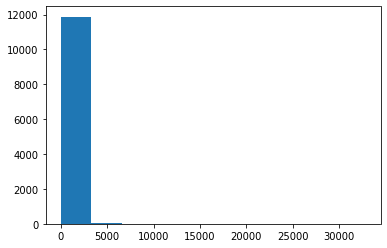

In [35]:
import matplotlib.pyplot as plt
plt.hist(result.wpm.tolist())

In [36]:
result.wpm.describe()

count    11959.000000
mean       327.206598
std        782.797110
min         10.099310
25%        157.722784
50%        207.089552
75%        284.877565
max      32812.500000
Name: wpm, dtype: float64

In [46]:
filtered = result[result.wpm < 500]

In [48]:
filtered.describe()

,duration,nSFD,nFFD,nGD,nTT,PrF,Pr1,Pr2,PrS,length,wpm
count,10905.000000,58.000000,10905.000000,10905.000000,10905.000000,10905.000000,10905.000000,10905.000000,10905.000000,10905.000000,10905.000000
mean,9181.616323,78.444181,56.171514,57.373040,114.835876,0.720781,0.265303,0.455478,0.279219,28.544613,213.969182
std,4163.132798,53.161021,17.168443,17.128216,48.125620,0.134123,0.122352,0.158601,0.134123,8.062898,83.691428
min,250.000000,31.261905,7.285714,7.285714,26.404762,0.200000,0.000000,0.000000,0.000000,2.000000,10.099310
25%,6713.000000,46.095238,46.719877,47.973700,87.696032,0.633333,0.187500,0.344828,0.187500,28.000000,153.178453
50%,9066.000000,58.642857,54.659369,55.885302,108.061077,0.733333,0.257143,0.451613,0.266667,30.000000,198.058252
75%,11627.000000,91.483631,63.625000,64.584410,133.323768,0.812500,0.333333,0.558824,0.366667,33.000000,256.571500
max,32557.000000,286.875000,714.000000,714.000000,1677.380952,1.000000,1.000000,1.000000,0.800000,37.000000,500.000000


In [54]:
filtered

,file,block,tokens,subject,duration,nSFD,nFFD,nGD,nTT,PrF,Pr1,Pr2,PrS,length,wpm
0,11,4,,001,10447,NaN,57.366304,58.540217,115.437319,0.821429,0.250000,0.571429,0.178571,28,160.811716
1,11,2,,001,11356,NaN,60.747985,61.331319,126.949679,0.812500,0.156250,0.656250,0.187500,32,169.073617
2,11,3,,001,17383,NaN,80.019118,80.577941,161.241503,0.944444,0.166667,0.777778,0.055556,36,124.259334
3,11,5,,001,7128,NaN,43.751948,48.321212,76.085660,0.733333,0.300000,0.433333,0.266667,30,252.525253
4,11,6,,001,6742,NaN,53.124901,53.124901,71.359127,0.685714,0.400000,0.285714,0.314286,35,311.480273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11954,92,3,,314,15071,NaN,57.090278,57.090278,143.746338,0.785714,0.178571,0.607143,0.214286,28,111.472364
11955,92,4,,314,7828,NaN,58.080349,58.761830,71.940513,0.870968,0.612903,0.258065,0.129032,31,237.608585
11956,92,5,,314,10443,NaN,59.135558,59.135558,90.611325,0.875000,0.468750,0.406250,0.125000,32,183.855214
11957,92,6,,314,5650,NaN,71.916106,71.916106,96.753268,0.485714,0.314286,0.171429,0.514286,35,371.681416


In [55]:
filtered.to_csv("eight_metrics_block_level.csv", index=False)

In [56]:
pd.read_csv("eight_metrics_block_level.csv")

,file,block,tokens,subject,duration,nSFD,nFFD,nGD,nTT,PrF,Pr1,Pr2,PrS,length,wpm
0,11,4,NaN,1,10447,NaN,57.366304,58.540217,115.437319,0.821429,0.250000,0.571429,0.178571,28,160.811716
1,11,2,NaN,1,11356,NaN,60.747985,61.331319,126.949679,0.812500,0.156250,0.656250,0.187500,32,169.073617
2,11,3,NaN,1,17383,NaN,80.019118,80.577941,161.241503,0.944444,0.166667,0.777778,0.055556,36,124.259334
3,11,5,NaN,1,7128,NaN,43.751948,48.321212,76.085660,0.733333,0.300000,0.433333,0.266667,30,252.525253
4,11,6,NaN,1,6742,NaN,53.124901,53.124901,71.359127,0.685714,0.400000,0.285714,0.314286,35,311.480273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10900,92,3,NaN,314,15071,NaN,57.090278,57.090278,143.746338,0.785714,0.178571,0.607143,0.214286,28,111.472364
10901,92,4,NaN,314,7828,NaN,58.080349,58.761830,71.940513,0.870968,0.612903,0.258065,0.129032,31,237.608585
10902,92,5,NaN,314,10443,NaN,59.135558,59.135558,90.611325,0.875000,0.468750,0.406250,0.125000,32,183.855214
10903,92,6,NaN,314,5650,NaN,71.916106,71.916106,96.753268,0.485714,0.314286,0.171429,0.514286,35,371.681416
